In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.optimize import curve_fit
import os

In [2]:
parent_path = os.path.dirname(os.path.dirname(os.getcwd()))
datapath = os.path.join(parent_path, 'redes', 'FAO')
os.listdir(datapath)

['coordinate-countries-fixed.csv',
 'edges.csv',
 'exports_by_country.csv',
 'exports_by_country_soja.csv',
 'FAO_manlio',
 'gprops copy.csv',
 'gprops-fixed.csv',
 'gprops.csv',
 'imports_by_country.csv',
 'imports_by_country_soja.csv',
 'net_trade_by_country.csv',
 'net_trade_by_country_soja.csv',
 'nodes-fixed.csv',
 'nodes-merged.csv',
 'nodes.csv',
 'not_nodes.csv',
 'ordered_nodes.csv',
 'total_trade_by_country.csv']

In [3]:
products = eval(open(os.path.join(datapath, "gprops-fixed.csv")).read())

def get_edges_by_layer(layer=0):
    all_edges = pd.read_csv(os.path.join(datapath, "edges.csv"))
    all_edges = all_edges.rename(
        columns={
            "# source": "source",
            " target": "target",
            " weight": "weight",
            " layer": "layer",
        }
    )

    unique_count = all_edges[["source", "target"]].values.flatten()
    unique_count = len(set(unique_count))

    one_layer_edges = all_edges[all_edges["layer"] == layer + 1]
    # Saco cuando source = target (que onda esto?)
    one_layer_edges = one_layer_edges[
        one_layer_edges["source"] != one_layer_edges["target"]
    ]
    # Filtro los paises que no estan en el dataframe (los que no tienen coordenadas)
    # one_layer_edges = one_layer_edges[one_layer_edges['source'].isin(merged_nodes['index']) & one_layer_edges['target'].isin(merged_nodes['index'])]

    del all_edges
    return one_layer_edges

In [17]:
def weight_distribution(weights, product='all', n_bins=200, scale=None, type='bar'):
    fig, ax = plt.subplots(dpi=150)
    ax.set_title(product)
    ax.set_xlabel('w')
    bins = np.linspace(0, scale, n_bins) if scale else np.linspace(0, int(np.mean(weights)), n_bins)
    ax.hist(weights, bins=bins, histtype=type);


def log_weight_distribution(weights, product='all', n_bins=50, scale=7, cumulative=False, density=False, type='bar'):
    fig, ax = plt.subplots(dpi=150)
    ax.set_title(product)
    ax.set_xlabel('w')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # logbins = range(0, 10**scale, n_bins) if cumulative else np.logspace(0, scale, n_bins)
    logbins = np.logspace(0, scale, n_bins)
    counts, bins, bars = ax.hist(weights, bins=logbins, cumulative=cumulative, density=density, histtype=type)
    return counts, bins, bars

def plot_both(weights, product='all', n_bins=200, log_n_bins=50, scale=None, logscale=7, xlabel=None, cumulative=False, type='bar', save=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
    fig.suptitle(product)
    ax1.set_xlabel(xlabel if xlabel else r'$w$')
    bins = np.linspace(0, scale, n_bins) if scale else np.linspace(0, int(np.mean(weights)), n_bins)
    ax2.set_xlabel(xlabel if xlabel else r'$w$')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    logbins = np.logspace(0, logscale, log_n_bins)
    ax1.hist(weights, bins=bins, histtype=type);
    ax2.hist(weights, bins=logbins, cumulative=cumulative, histtype=type)
    if save:
        plt.savefig(save, format='svg')



### Un poco de estadistica de cada Layer

In [5]:
full_dataset = [get_edges_by_layer(layer) for layer in products.keys()]

In [7]:
full_dataset[0]['weight'].count()

3993

In [10]:
means = [np.round(np.mean(data['weight']), 2) for data in full_dataset]
counts = [(data['weight']).count() for data in full_dataset]
sums = [np.sum(data['weight']) for data in full_dataset]
print("----------------------------------------------------------------------------------")
print("Producto con menor <w>:", products[means.index(np.min(means))],'\t\t\t',  np.min(means))
print("Producto con mayor <w>:", products[means.index(np.max(means))],'\t\t\t\t', "{:.2f}".format(np.max(means)))
print("----------------------------------------------------------------------------------")
print("Producto con menor cantidad de links:", products[counts.index(np.min(counts))],'\t\t',  np.min(counts))
print("Producto con mayor cantidad de links:", products[counts.index(np.max(counts))],'\t\t', "{:.2f}".format(np.max(counts)))
print("----------------------------------------------------------------------------------")
print("Producto con menor volumen (en usd):", products[sums.index(np.min(sums))],'\t',  np.min(sums))
print("Producto con mayor volumen (en usd):", products[sums.index(np.max(sums))],'\t\t\t', "{:.2f}".format(np.max(sums)))
print("----------------------------------------------------------------------------------")
print(counts[sums.index(np.max(sums))])

----------------------------------------------------------------------------------
Producto con menor <w>: Pyrethrum,_extraction 			 2.0
Producto con mayor <w>: Soybeans 				 75486.97
----------------------------------------------------------------------------------
Producto con menor cantidad de links: Buffaloes 		 1
Producto con mayor cantidad de links: Food_prep_nes 		 6514.00
----------------------------------------------------------------------------------
Producto con menor volumen (en usd): Pyrethrum,_extraction 	 2
Producto con mayor volumen (en usd): Soybeans 			 69221554.00
----------------------------------------------------------------------------------
917


In [23]:
# Cantidad de links de en la capa 'soybeans'
d = {products[i]: counts[i] for i in range(len(products))}
vol = {products[i]: sums[i] for i in range(len(products))}
# sort d by value
sorted_d = sorted(d.items(), key=lambda x: x[1], reverse=True)
sorted_d
sorted_vol = sorted(vol.items(), key=lambda x: x[1], reverse=True)
sorted_vol

[('Soybeans', 69221554),
 ('Food_prep_nes', 44352784),
 ('Crude_materials', 35938991),
 ('Wine', 29294581),
 ('Oil,_palm', 28715891),
 ('Wheat', 27173155),
 ('Rubber_natural_dry', 25649375),
 ('Maize', 23764947),
 ('Beverages,_distilled_alcoholic', 23599992),
 ('Meat,_cattle,_boneless_(beef_&_veal)', 23342672),
 ('Cake,_soybeans', 22970989),
 ('Cheese,_whole_cow_milk', 21276193),
 ('Cigarettes', 20537138),
 ('Cotton_lint', 19583722),
 ('Pastry', 19220993),
 ('Chocolate_products_nes', 18591759),
 ('Coffee,_green', 17987761),
 ('Meat,_chicken', 17145871),
 ('Meat,_pork', 15297701),
 ('Sugar_Raw_Centrifugal', 14587033),
 ('Tobacco,_unmanufactured', 12526764),
 ('Fruit,_prepared_nes', 12250355),
 ('Beverages,_non_alcoholic', 12239256),
 ('Rice,_milled', 11886391),
 ('Bananas', 11875952),
 ('Sugar_refined', 10365468),
 ('Beer_of_barley', 10329366),
 ('Meat,_pig', 9983486),
 ('Cocoa,_beans', 9644449),
 ('Pet_food', 9092049),
 ('Rapeseed', 8567953),
 ('Oil,_soybean', 8318863),
 ('Sugar_confec

In [8]:
stats = pd.DataFrame(
        {'Products': products.values(),
         '# Links': counts,
         'w_mean': means,
         'Volume (1000 USD)': sums
        })
stats   

NameError: name 'counts' is not defined

In [9]:
stats.sort_values(by='# Links')

,Products,# Links,w_mean,Volume (1000 USD)
289,"Pyrethrum,_extraction",1,2.00,2
136,Buffaloes,1,796.00,796
288,"Offals,_edible,_goats",1,3.00,3
279,Persimmons,4,537.75,2151
286,Gooseberries,5,370.40,1852
...,...,...,...,...
294,Sugar_confectionery,4228,1929.70,8158767
28,"Fruit,_prepared_nes",4313,2840.33,12250355
152,Pastry,4473,4297.11,19220993
23,Crude_materials,6393,5621.62,35938991


In [10]:
stats.sort_values(by='w_mean')

,Products,# Links,w_mean,Volume (1000 USD)
289,"Pyrethrum,_extraction",1,2.00,2
288,"Offals,_edible,_goats",1,3.00,3
276,Mules,13,3.85,50
287,Peppermint,8,6.00,48
133,Asses,24,15.42,370
...,...,...,...,...
327,Rubber_natural_dry,1344,19084.36,25649375
293,Wheat,1217,22327.98,27173155
172,"Oil,_palm",1210,23732.14,28715891
12,"Cake,_soybeans",797,28821.82,22970989


In [11]:
stats.sort_values(by='Volume (1000 USD)')

,Products,# Links,w_mean,Volume (1000 USD)
289,"Pyrethrum,_extraction",1,2.00,2
288,"Offals,_edible,_goats",1,3.00,3
287,Peppermint,8,6.00,48
276,Mules,13,3.85,50
133,Asses,24,15.42,370
...,...,...,...,...
172,"Oil,_palm",1210,23732.14,28715891
301,Wine,3326,8807.75,29294581
23,Crude_materials,6393,5621.62,35938991
2,Food_prep_nes,6514,6808.84,44352784


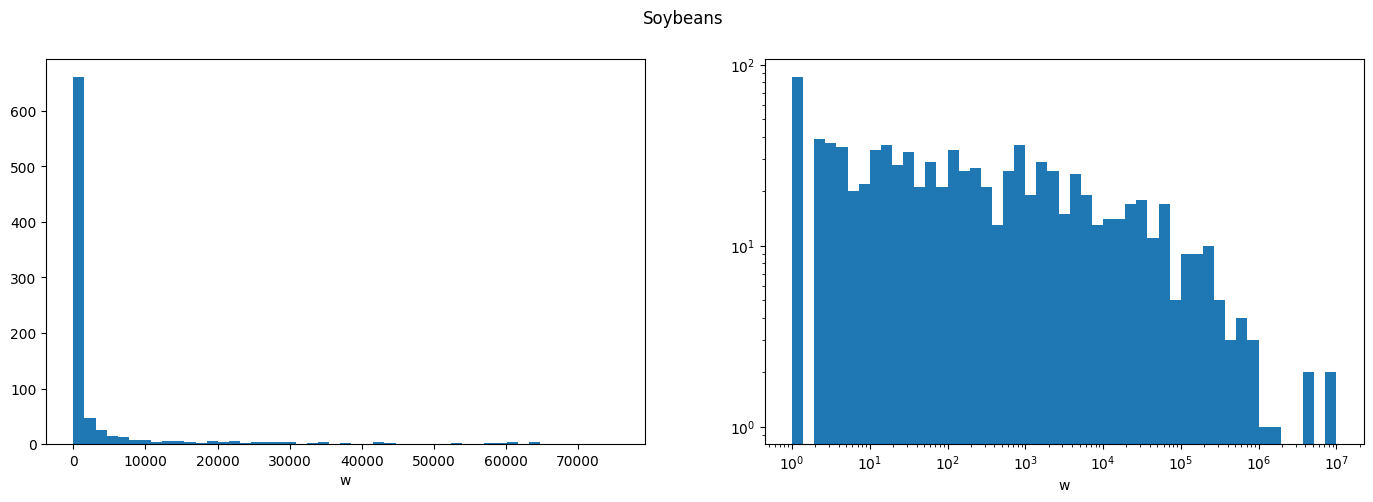

In [9]:
layer = 344
df = get_edges_by_layer(layer=layer)
plot_both(df['weight'], products[layer], n_bins=50)

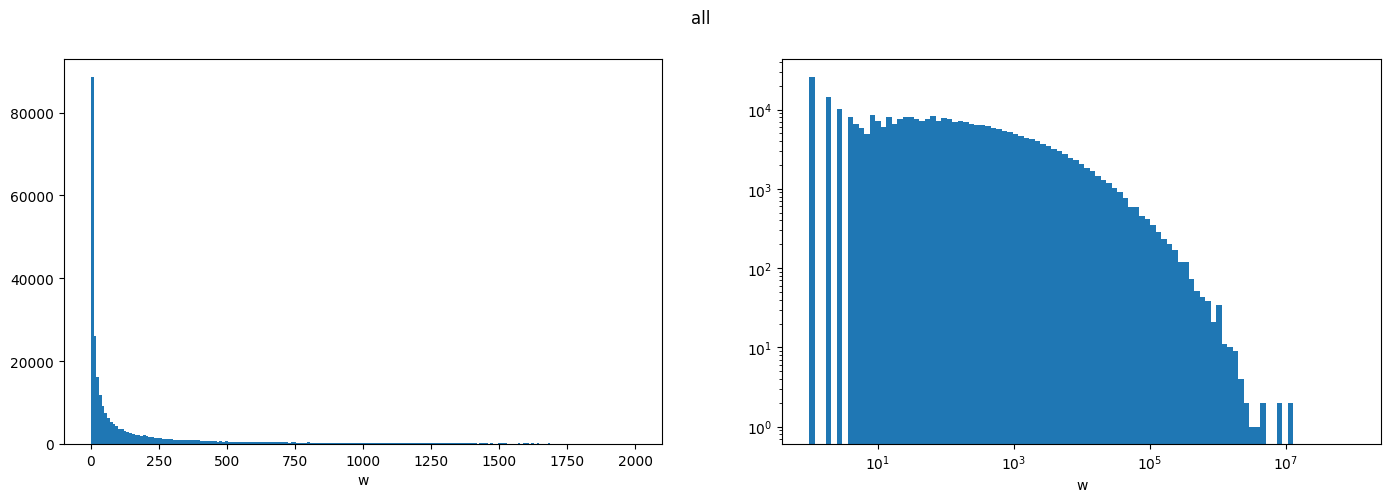

In [13]:
# all_weights = [full_dataset[layer]['weight'] / np.mean(full_dataset[layer]['weight']) for layer in products.keys()] 
all_weights = [full_dataset[layer]['weight'] for layer in products.keys()] 
all_weights = [item for row in all_weights for item in row]

plot_both(all_weights, n_bins=200, log_n_bins=100, scale=2000, logscale=8)
# del all_weights

### Calculemos la 'fuerza' de los nodos

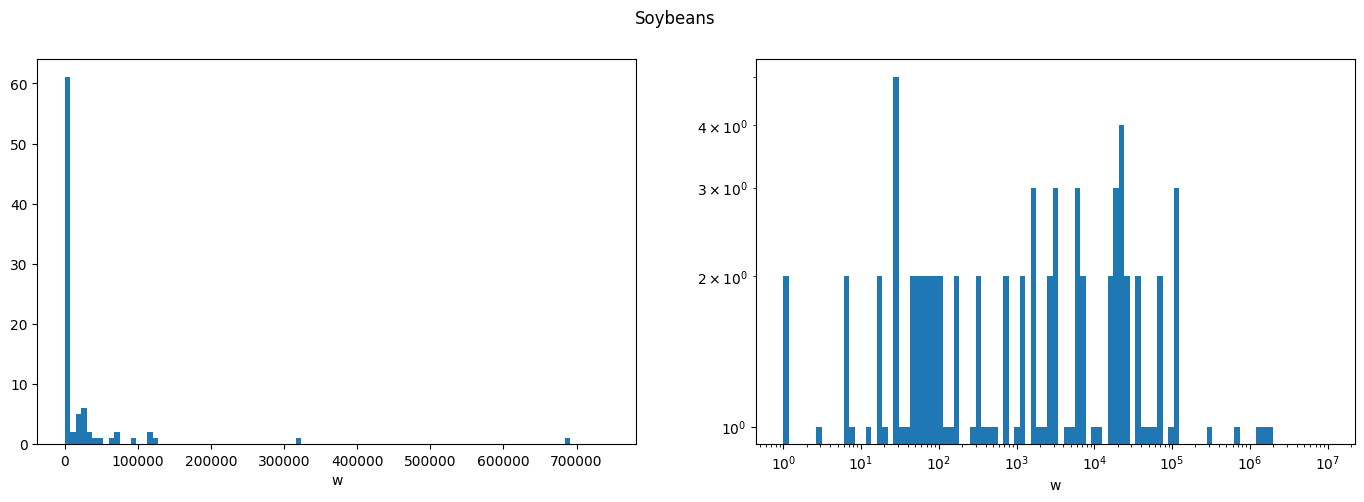

In [14]:
layer = 344
df = get_edges_by_layer(layer)
# df['weight'] /= np.mean(df['weight'])

# Group by 'source' and sum the 'weight' column
grouped = df.groupby('source')['weight'].sum()
# Convert the grouped Series to a dictionary
export_strength = grouped.to_dict()

grouped = df.groupby('target')['weight'].sum()
# Convert the grouped Series to a dictionary
import_strength = grouped.to_dict()

plot_both(list(export_strength.values()), products[layer], n_bins=100, log_n_bins=100)

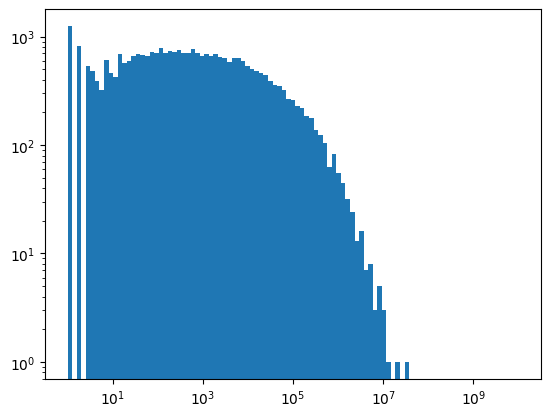

In [149]:

# log_weight_distribution(export_strength, product='Export strength', n_bins=100, scale=10, density=False);
plt.hist(export_strength, bins=np.logspace(0, 10, 100), density=False, stacked=True);
plt.xscale('log')
plt.yscale('log')

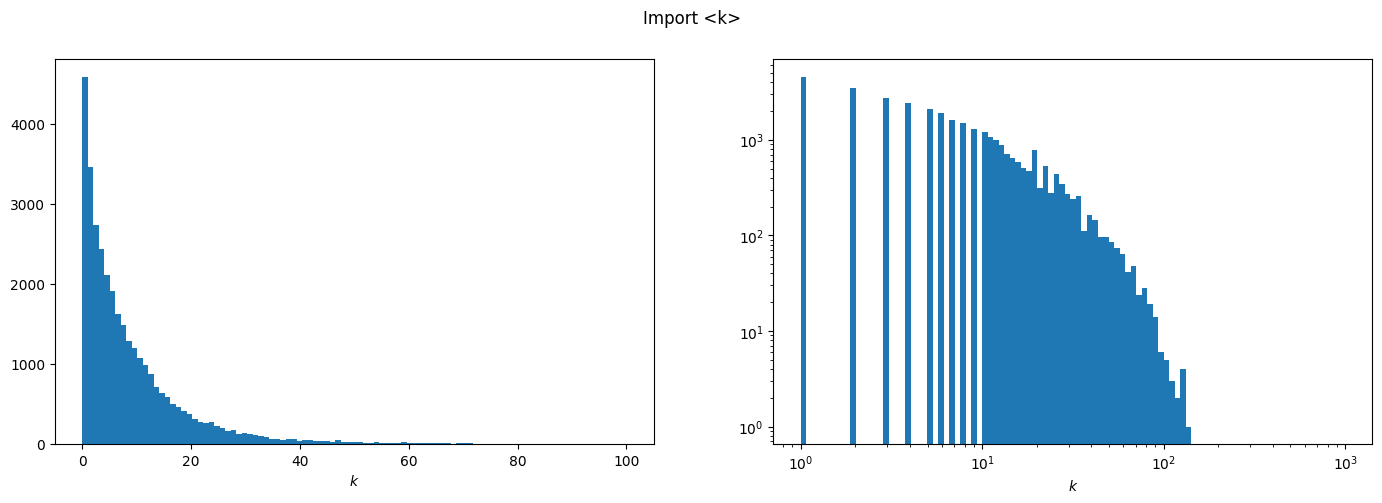

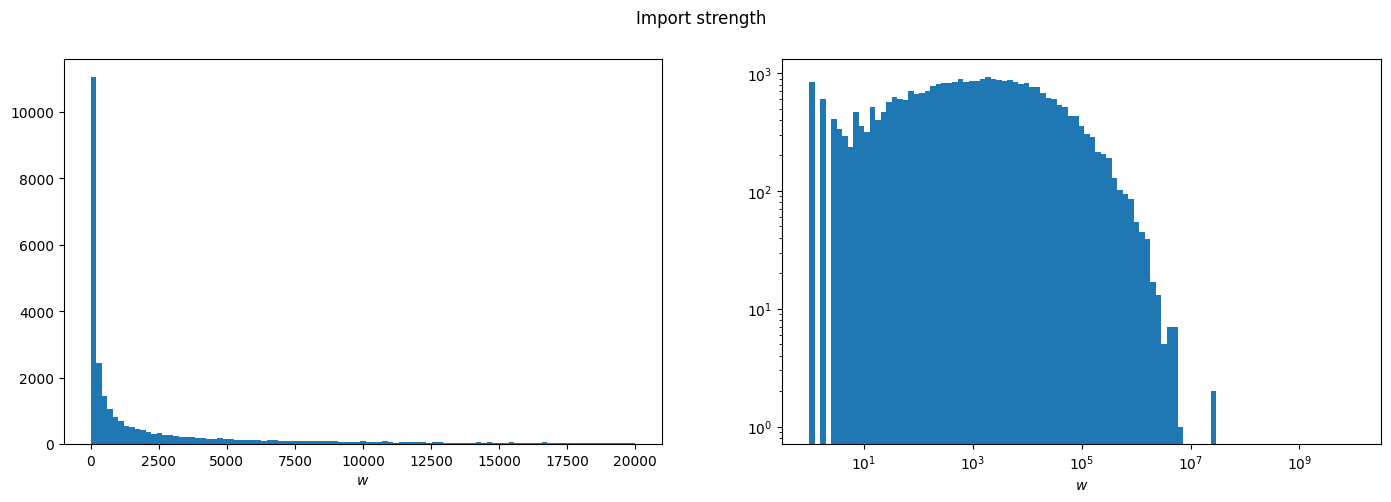

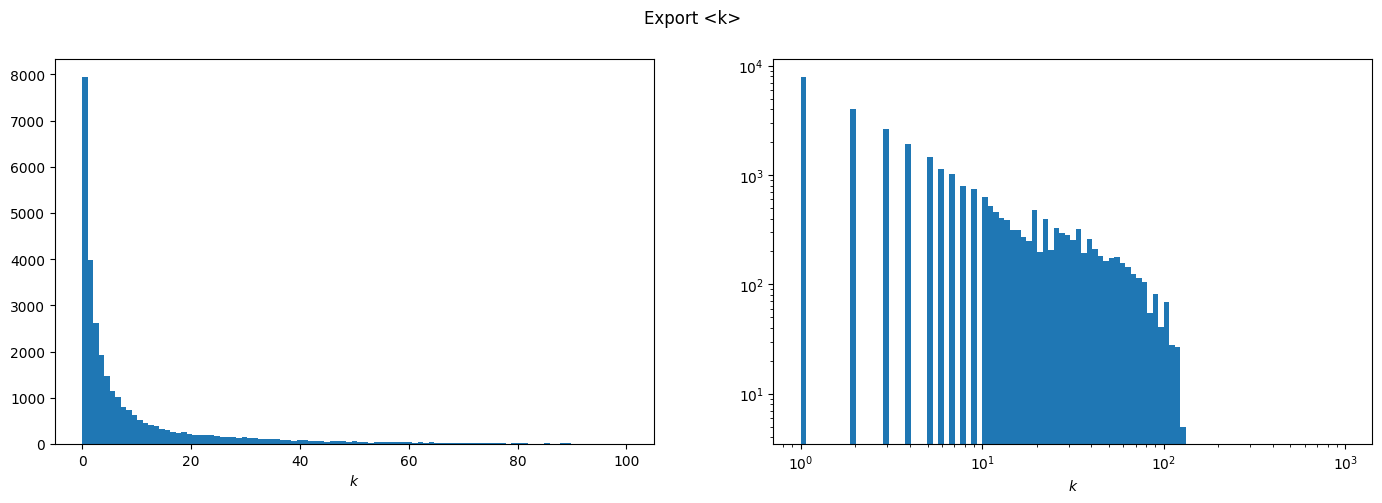

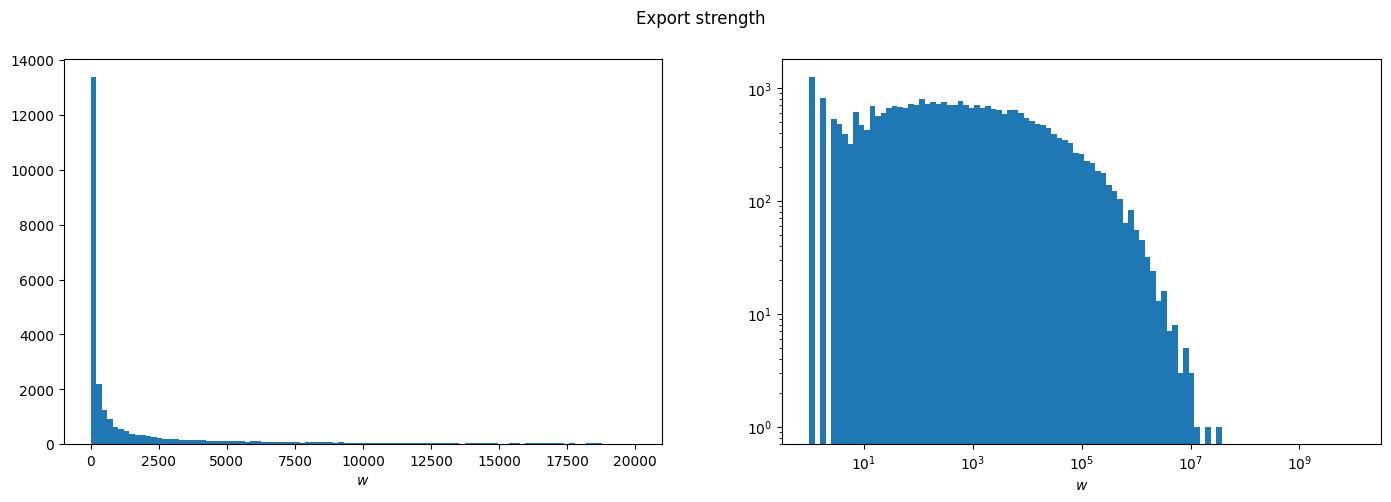

In [26]:
all_data = [full_dataset[layer] for layer in products.keys()] 

# Group by 'source' and sum the 'weight' column
# import_grouped = [data.groupby('target')['weight'].sum() / np.mean(data['weight']) for data in all_data]
# export_grouped = [data.groupby('source')['weight'].sum() / np.mean(data['weight']) for data in all_data]
# Sin normalizar?
import_grouped = [data.groupby('target')['weight'].sum()  for data in all_data]
import_grouped_neighs = [data.groupby('target')['weight'].count()  for data in all_data]
export_grouped = [data.groupby('source')['weight'].sum()  for data in all_data]
export_grouped_neighs = [data.groupby('source')['weight'].count()  for data in all_data]

# Totales por producto, el histograma es el de todos los productos juntos
import_strength = [item for row in import_grouped for item in row]
import_neighs = [item for row in import_grouped_neighs for item in row]
export_strength = [item for row in export_grouped for item in row]
export_neighs = [item for row in export_grouped_neighs for item in row]

del import_grouped, import_grouped_neighs, export_grouped, export_grouped_neighs

plot_both(import_neighs, product='Import <k>', n_bins=100, scale=100, log_n_bins=100, logscale=3, xlabel=r'$k$', save=os.path.join(os.getcwd(), 'figs', 'import_neighs.svg'))
plot_both(import_strength, product='Import strength', n_bins=100, log_n_bins=100, scale=20000, logscale=10)
plot_both(export_neighs, product='Export <k>', n_bins=100, scale=100, log_n_bins=100, logscale=3, xlabel=r'$k$', save=os.path.join(os.getcwd(), 'figs', 'export_neighs.svg'))
plot_both(export_strength, product='Export strength', n_bins=100, log_n_bins=100, scale=20000, logscale=10)

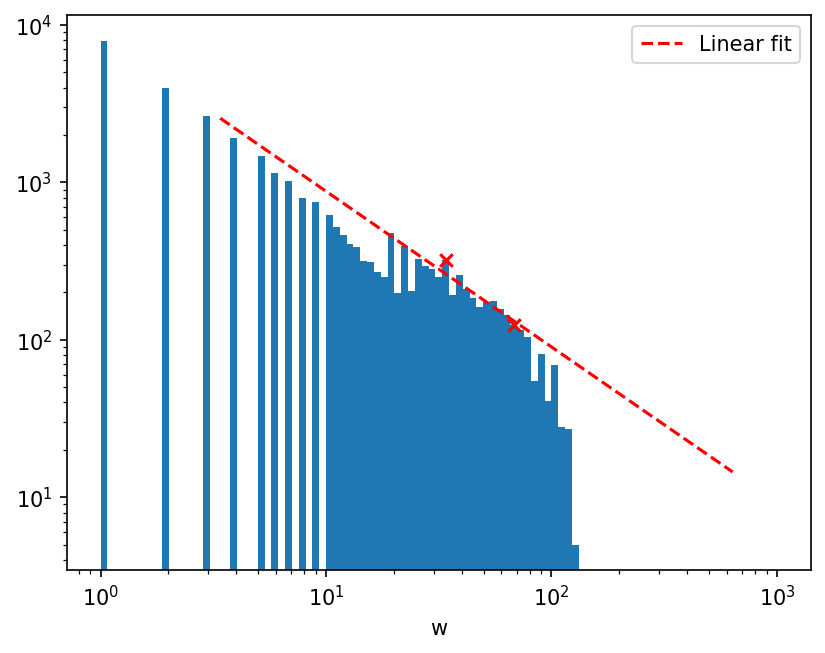

In [16]:
fig, ax = plt.subplots(dpi=150)
n_bins=100
ax.set_xlabel('w')
ax.set_xscale('log')
ax.set_yscale('log')
logbins = np.logspace(0, 3, n_bins)
counts, bins, bars = ax.hist(export_neighs, bins=logbins)

# Fit a linear function to the last 10 bins of the histogram
start = 50
end = 60
x = (bins[start:end] + bins[start+1:end+1]) / 2
y = counts[start:end]
p = np.polyfit(np.log10(x), np.log10(y), 1)

# Plot the linear function
x_fit = np.logspace(np.log10(x[0])-1, np.log10(x[-1])+1, 100)
y_fit = 10**(np.polyval(p, np.log10(x_fit)))
ax.plot(x_fit, y_fit, 'r--', label='Linear fit')
ax.scatter((bins[start] + bins[start+1]) / 2, counts[start], c='r', marker='x')
ax.scatter((bins[end] + bins[end+1]) / 2, counts[end], c='r', marker='x')

ax.legend()
plt.show()


In [17]:
# Define the functions to fit
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def power_law(x, a, b, c):
    return a / x ** (b + 1) + c

def linear_hist_fits(data, scale, title=None, xaxis='w', n_bins=100, start=0, end=n_bins-2, verbose=False):
    fig, ax = plt.subplots(dpi=150)
    ax.set_xlabel(xaxis)
    ax.set_title(title)
    bins = np.linspace(0, scale, n_bins) 
    counts, bins, bars = ax.hist(data, bins=bins)
    x = (bins[start:end] + bins[start+1:end+1]) / 2
    y = counts[start:end]
    popt_exp, var_exp = curve_fit(exp_decay, x, y)
    popt_pl, var_pl = curve_fit(power_law, x, y)
    # Plot the histogram and fitted functions
    ax.plot(x, exp_decay(x, *popt_exp), 'r--', label='Decaying exponential fit')
    ax.plot(x, power_law(x, *popt_pl), 'g--', label='Power law fit')
    ax.scatter((bins[start] + bins[start+1]) / 2, counts[start], c='black', marker='x')
    ax.scatter((bins[end] + bins[end+1]) / 2, counts[end], c='black', marker='x')
    ax.legend()
    if verbose:
        print("-----------------------------")
        print("Exponential fit:")
        for val, err in zip(popt_exp, np.sqrt(np.diag(var_exp))):
            print("{:.2f} +- {:.2f}".format(val, err))
        print("-----------------------------")
        print("Power law fit:")
        for val, err in zip(popt_pl, np.sqrt(np.diag(var_pl))):
            print("{:.2f} +- {:.2f}".format(val, err))
        print("-----------------------------")
        
    plt.show()
    return popt_exp, var_exp, popt_pl, var_pl

/tmp/ipykernel_11233/1751653247.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/tmp/ipykernel_11233/1751653247.py:6: RuntimeWarning: divide by zero encountered in divide
  return a / x ** (b + 1) + c
/tmp/ipykernel_11233/1751653247.py:6: RuntimeWarning: overflow encountered in divide
  return a / x ** (b + 1) + c


-----------------------------
Exponential fit:
3536.52 +- 61.28
0.12 +- 0.00
10.83 +- 2.48
-----------------------------
Power law fit:
34465.55 +- 3745.01
0.46 +- 0.05
-83.26 +- 11.53
-----------------------------


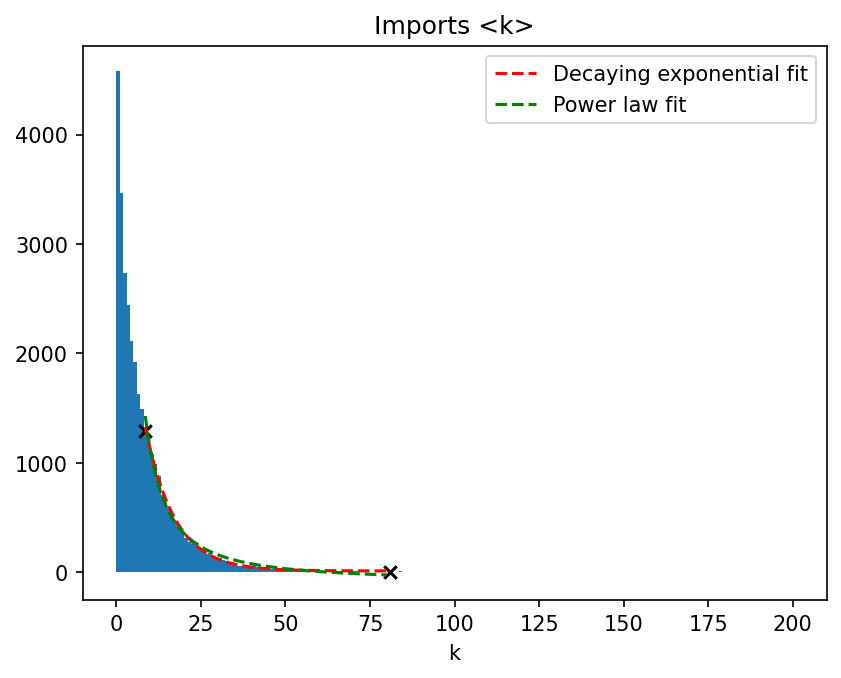

/home/lautaro/anaconda3/envs/abm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


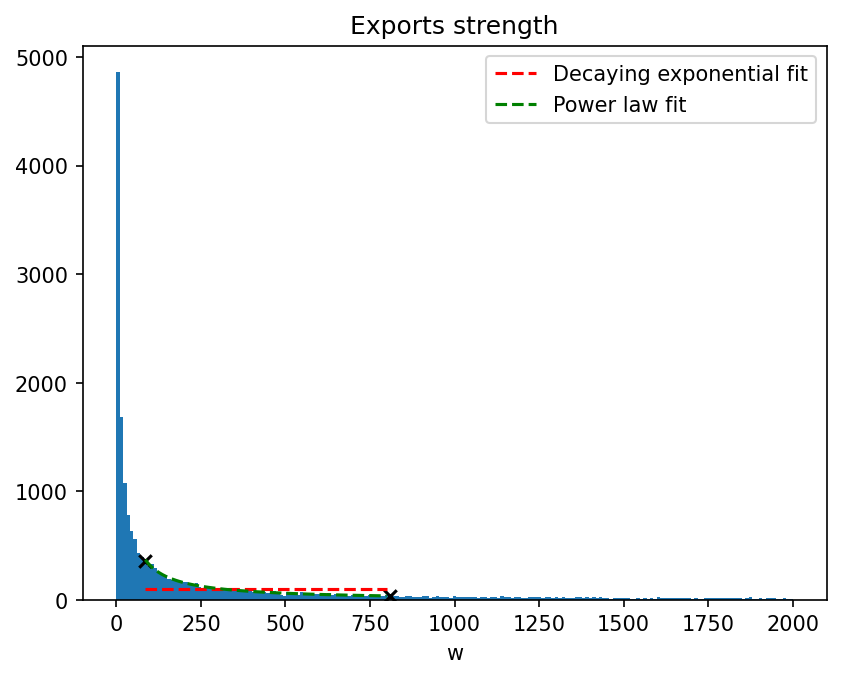

In [18]:
exp, var_exp, pl, var_pl = linear_hist_fits(import_neighs, title='Imports <k>', xaxis='k', scale=200, n_bins=200, start=8, end=80, verbose=True)
# exp2, var_exp2, pl2, var_pl2 = linear_hist_fits(export_neighs, title='Exports <k>', xaxis='k', scale=200, n_bins=200, start=8, end=80)
# exp3, var_exp3, pl3, var_pl3 = linear_hist_fits(import_strength, title='Imports strength', scale=2000, n_bins=200, start=8, end=80)
exp4, var_exp4, pl4, var_pl4 = linear_hist_fits(export_strength, title='Exports strength', scale=2000, n_bins=200, start=8, end=80)

## 25/9: Mejores fits

In [63]:
# f(x) = a / (x ** b)
def linear_fit(x, a, b):
    return a + b * x

def exp_fit(x, a, b):
    return a + b * np.exp(x)

#### Fiteando la distribucion de pesos

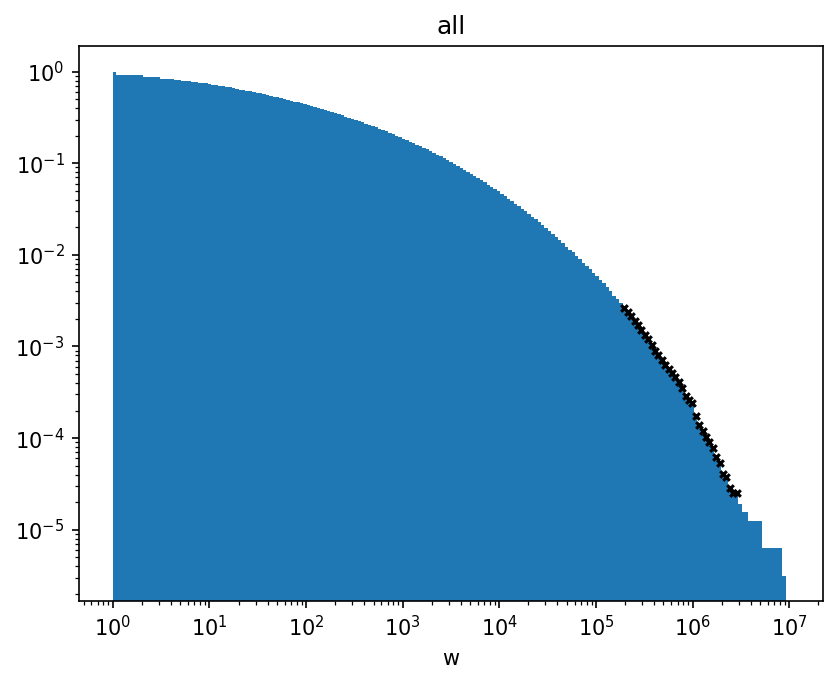

y = m*x + b
m = -1.794 +- 0.032
b = 16.17 +- 0.43


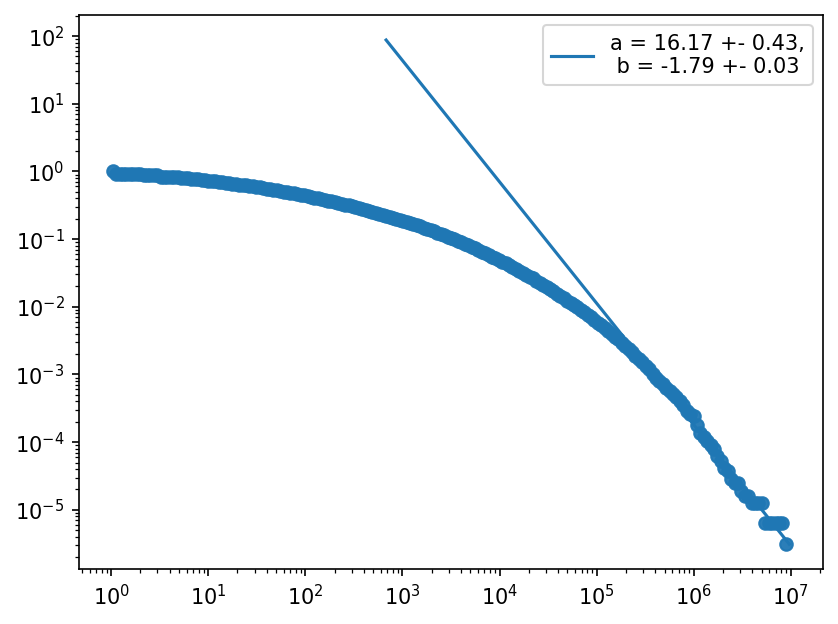

In [20]:
all_y, all_x, bars = log_weight_distribution(all_weights, n_bins=200, scale=7, cumulative=-1, density=True)
# plt.scatter(counts)
all_x = (all_x[:-1] + all_x[1:]) / 2
start = 150
end = -15
y = all_y[start:end]
x = all_x[start:end]
plt.scatter(x, y, marker='x', color='black', s=10)
plt.show()

# Perform linear regression on the log-log scale
fit, cov = np.polyfit(np.log(x), np.log(y), deg=1, cov=True)

fig = plt.figure(dpi=150)
# Plot the original data points
plt.scatter(all_x, all_y, alpha=0.95)

# Plot the fitted line on the log-log scale
plt.plot(all_x[80:], np.exp(fit[1]) * all_x[80:]**fit[0], label=f'a = {fit[1]:.2f} +- {np.sqrt(cov[1,1]):.2f},\n b = {fit[0]:.2f} +- {np.sqrt(cov[0,0]):.2f}')

# Set the axes to log scale
plt.yscale('log')
plt.xscale('log')
plt.legend()

err = np.sqrt(np.diag(cov))

# Show the plot
print(f"y = m*x + b")
print(f"m = {fit[0]:.3f} +- {err[0]:.3f}")
print(f"b = {fit[1]:.2f} +- {err[1]:.2f}")
plt.show()

### Fiteando la distribucion de 'fuerza'

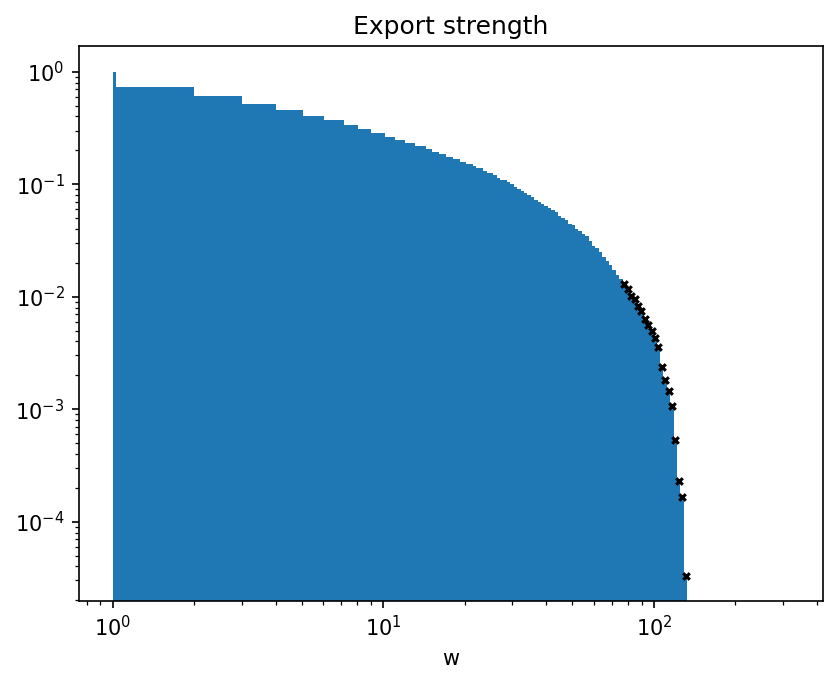

In [21]:
all_y, all_x, bars = log_weight_distribution(export_neighs, n_bins=200, scale=2.5, cumulative=-1, density=True)
# plt.scatter(counts)
all_x = (all_x[:-1] + all_x[1:]) / 2
start = 150
end = -20
y = all_y[start:end]
x = all_x[start:end]
plt.scatter(x, y, marker='x', color='black', s=10)
plt.title('Export strength');

/tmp/ipykernel_11233/3725949661.py:2: RuntimeWarning: divide by zero encountered in log
  fit, cov = np.polyfit(np.log(x), np.log(y), deg=1, cov=True)


y = m*x + b
m = nan +- nan
b = nan +- nan


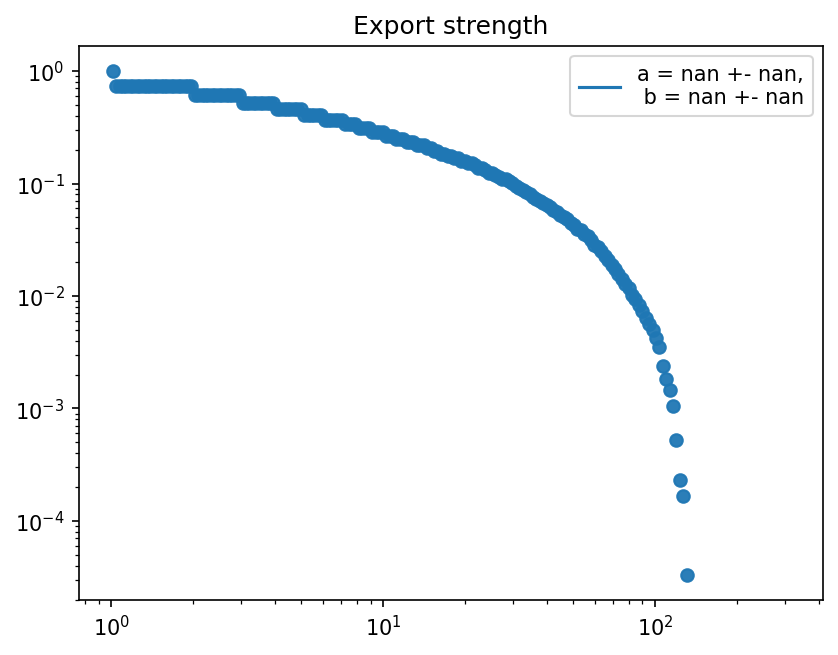

In [22]:
# Perform linear regression on the log-log scale
fit, cov = np.polyfit(np.log(x), np.log(y), deg=1, cov=True)

fig = plt.figure(dpi=150)
# Plot the original data points
plt.scatter(all_x, all_y, alpha=0.95)

# Plot the fitted line on the log-log scale
plt.plot(all_x[80:], np.exp(fit[1]) * all_x[80:]**fit[0], label=f'a = {fit[1]:.2f} +- {np.sqrt(cov[1,1]):.2f},\n b = {fit[0]:.2f} +- {np.sqrt(cov[0,0]):.2f}')

# Set the axes to log scale
plt.yscale('log')
plt.xscale('log')
plt.title('Export strength')
plt.legend()

err = np.sqrt(np.diag(cov))

# Show the plot
print(f"y = m*x + b")
print(f"m = {fit[0]:.3f} +- {err[0]:.3f}")
print(f"b = {fit[1]:.2f} +- {err[1]:.2f}")
plt.show()

#### Para exportaciones

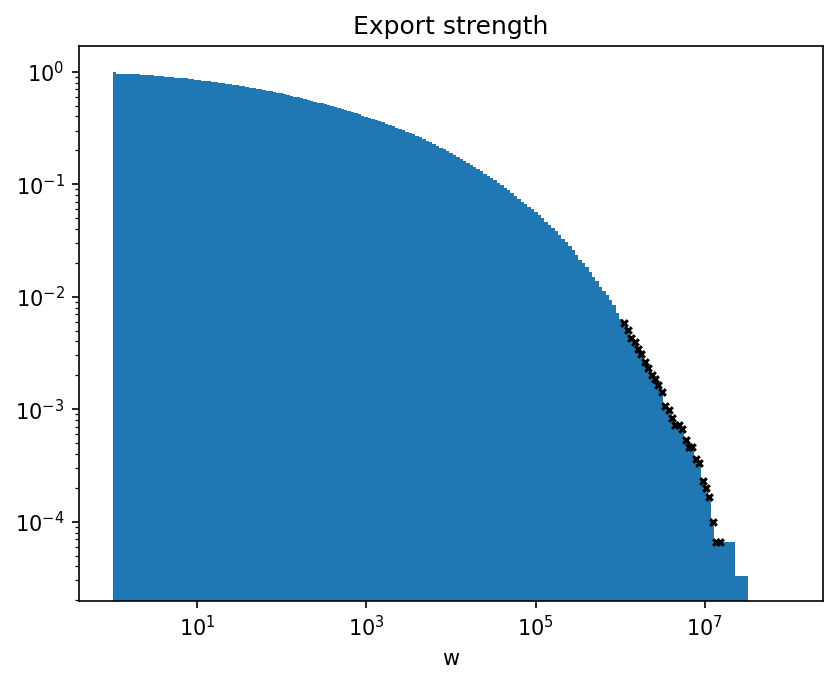

In [23]:
all_y, all_x, bars = log_weight_distribution(export_strength, n_bins=200, scale=8, cumulative=-1, density=True)
# plt.scatter(counts)
all_x = (all_x[:-1] + all_x[1:]) / 2
start = 150
end = -20
y = all_y[start:end]
x = all_x[start:end]
plt.scatter(x, y, marker='x', color='black', s=10)
plt.title('Export strength');

y = m*x + b
m = -1.620 +- 0.048
b = 17.57 +- 0.74


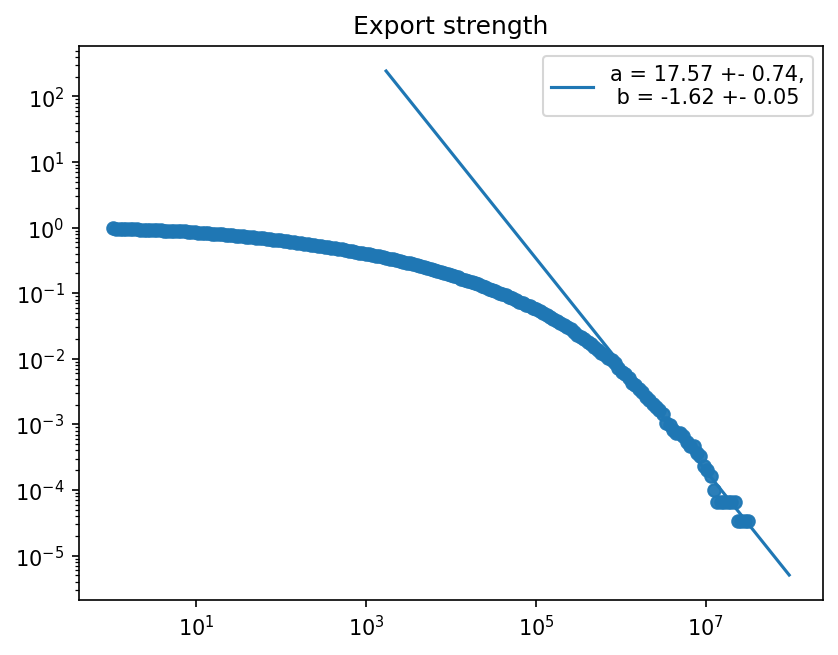

In [24]:
# Perform linear regression on the log-log scale
fit, cov = np.polyfit(np.log(x), np.log(y), deg=1, cov=True)

fig = plt.figure(dpi=150)
# Plot the original data points
plt.scatter(all_x, all_y, alpha=0.95)

# Plot the fitted line on the log-log scale
plt.plot(all_x[80:], np.exp(fit[1]) * all_x[80:]**fit[0], label=f'a = {fit[1]:.2f} +- {np.sqrt(cov[1,1]):.2f},\n b = {fit[0]:.2f} +- {np.sqrt(cov[0,0]):.2f}')

# Set the axes to log scale
plt.yscale('log')
plt.xscale('log')
plt.title('Export strength')
plt.legend()

err = np.sqrt(np.diag(cov))

# Show the plot
print(f"y = m*x + b")
print(f"m = {fit[0]:.3f} +- {err[0]:.3f}")
print(f"b = {fit[1]:.2f} +- {err[1]:.2f}")
plt.show()

#### Para importaciones

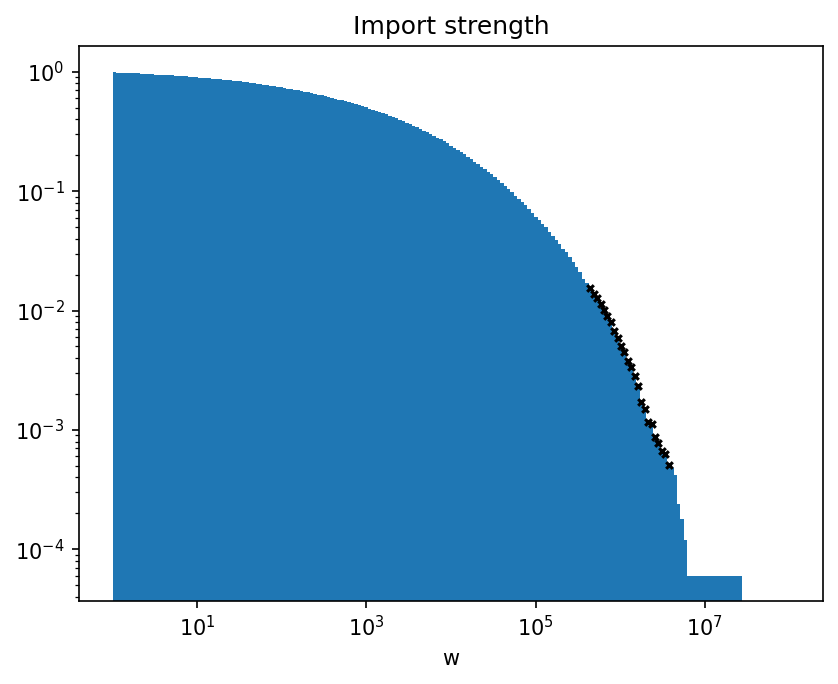

In [89]:
all_y, all_x, bars = log_weight_distribution(import_strength, n_bins=200, scale=8, cumulative=-1, density=True)
# plt.scatter(counts)
all_x = (all_x[:-1] + all_x[1:]) / 2
start = 140
end = -35
y = all_y[start:end]
x = all_x[start:end]
plt.scatter(x, y, marker='x', color='black', s=10)
plt.title('Import strength');

y = m*x + b
m = -1.680 +- 0.031
b = 17.87 +- 0.44


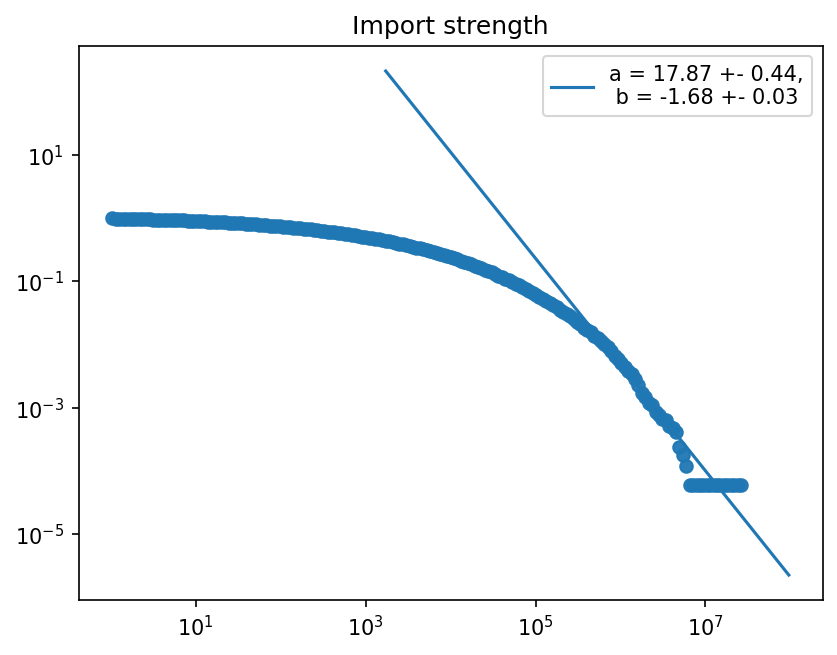

In [90]:
# Perform linear regression on the log-log scale
fit, cov = np.polyfit(np.log(x), np.log(y), deg=1, cov=True)

fig = plt.figure(dpi=150)
# Plot the original data points
plt.scatter(all_x, all_y, alpha=0.95)

# Plot the fitted line on the log-log scale
plt.plot(all_x[80:], np.exp(fit[1]) * all_x[80:]**fit[0], label=f'a = {fit[1]:.2f} +- {np.sqrt(cov[1,1]):.2f},\n b = {fit[0]:.2f} +- {np.sqrt(cov[0,0]):.2f}')

# Set the axes to log scale
plt.yscale('log')
plt.xscale('log')
plt.title('Import strength')
plt.legend()

err = np.sqrt(np.diag(cov))

# Show the plot
print(f"y = m*x + b")
print(f"m = {fit[0]:.3f} +- {err[0]:.3f}")
print(f"b = {fit[1]:.2f} +- {err[1]:.2f}")
plt.show()

#### Fiteando el neto

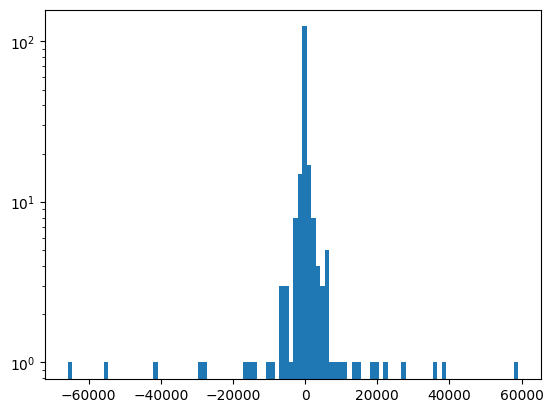

In [145]:
# Histograma de exportaciones netas, que este centrado en 0 le da mas validez estadistica
# de ser un buen muestreo de las importaciones/exportaciones totales?
data = pd.read_csv(os.path.join(datapath, 'net_trade_by_country.csv'))
plt.hist(data['net_trade (m usd)'], bins=100);
plt.yscale('log')

## 2/10: Fiteo general de las distribuciones

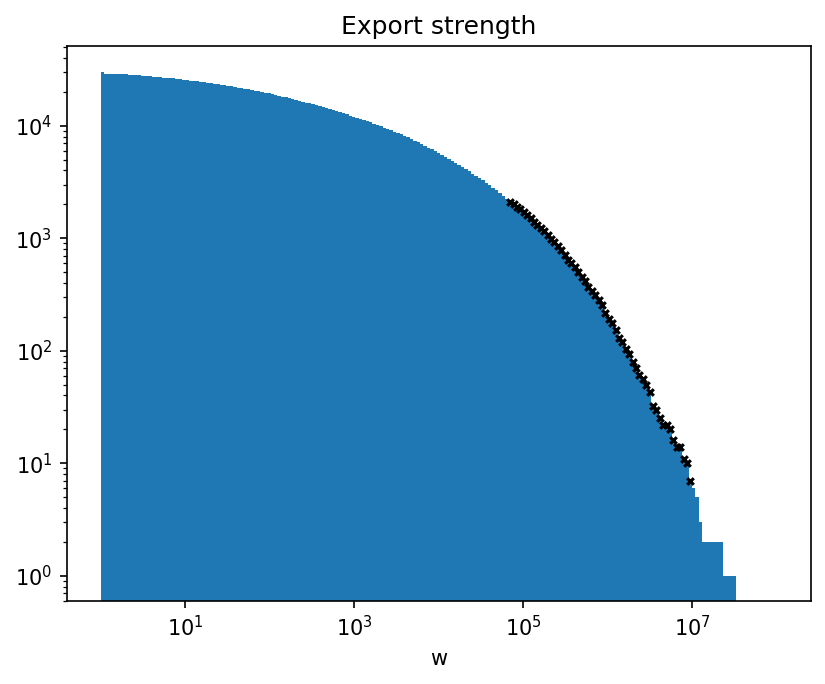

In [98]:
all_y, all_x, bars = log_weight_distribution(export_strength, n_bins=200, scale=8, cumulative=-1, density=False)
# plt.scatter(counts)
all_x = (all_x[:-1] + all_x[1:]) / 2
start = 120
end = -25
y = all_y[start:end]
x = all_x[start:end]
plt.scatter(x, y, marker='x', color='black', s=10)
plt.title('Export strength');

y = m*x + b
m = -1.160 +- 0.021
b = 21.08 +- 0.29


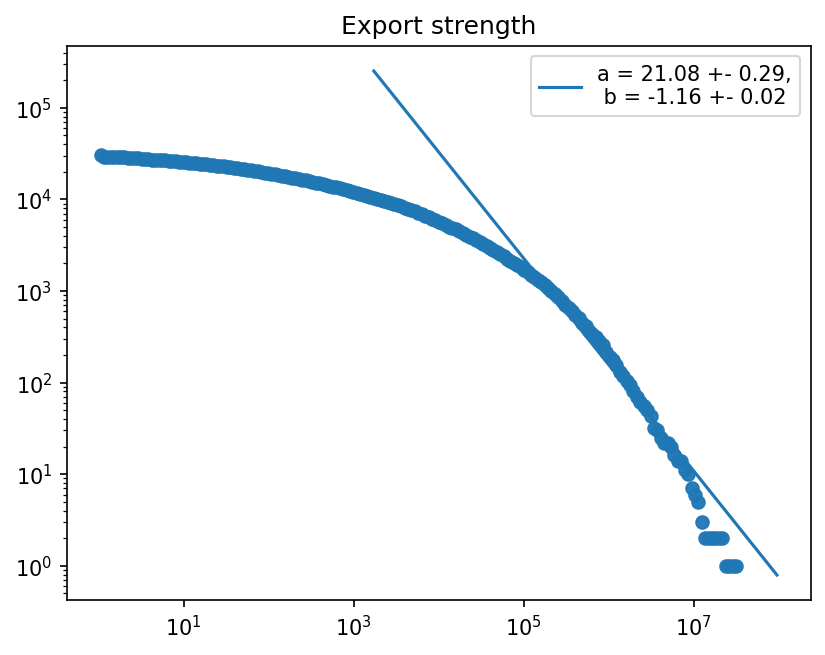

In [99]:
def exp_fit(x, a, b):
    return a - b * 10**(x)

# Perform linear regression on the log-log scale
# fit, cov = np.polyfit(np.log(x), np.log(y), deg=1, cov=True)
fit, cov = curve_fit(linear_fit, np.log(x), np.log(y));

fig = plt.figure(dpi=150)
# Plot the original data points
plt.scatter(all_x, all_y, alpha=0.95)

# Plot the fitted line on the log-log scale
plt.plot(all_x[80:], np.exp(fit[0]) * all_x[80:]**fit[1], label=f'a = {fit[0]:.2f} +- {np.sqrt(cov[0,0]):.2f},\n b = {fit[1]:.2f} +- {np.sqrt(cov[1,1]):.2f}')

# Set the axes to log scale
plt.yscale('log')
plt.xscale('log')
plt.title('Export strength')
plt.legend()

err = np.sqrt(np.diag(cov))

# Show the plot
print(f"y = m*x + b")
print(f"m = {fit[1]:.3f} +- {err[1]:.3f}")
print(f"b = {fit[0]:.2f} +- {err[0]:.2f}")
plt.show()

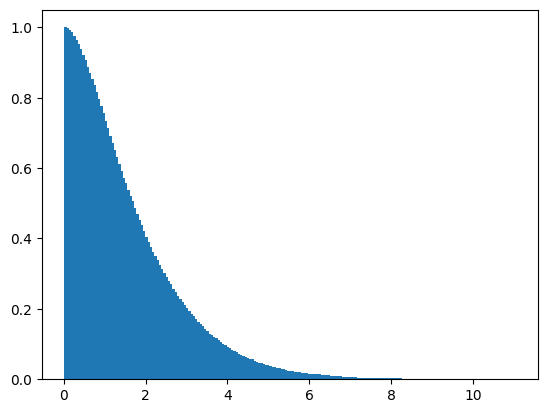

In [119]:
data = np.random.gamma(2, 1, 10000)
plt.hist(data, bins=200, cumulative=-1, density=True);